In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


# **Importing Modules**

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import r2_score

# **Loading The Datasets**

In [3]:
# =================================================================================
# STEP 1 & 2: DATA PREP AND FEATUREENGINEER CLASS
# =================================================================================
print("--- Step 1 & 2: Preparing data and defining FeatureEngineer ---")
train_raw = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
test_raw = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')

--- Step 1 & 2: Preparing data and defining FeatureEngineer ---


# **Creating  Copies of Train and Test Datasets**

In [4]:
import pandas as pd

# Load the training and test datasets
train_df = train_raw.copy()
test_df = test_raw.copy()

# Display basic info to verify successful loading
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

Train Shape: (116023, 52)
Test Shape: (29006, 51)


# **EDA**

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding                   11

# **Plotting the Null Value Percentages of each column**

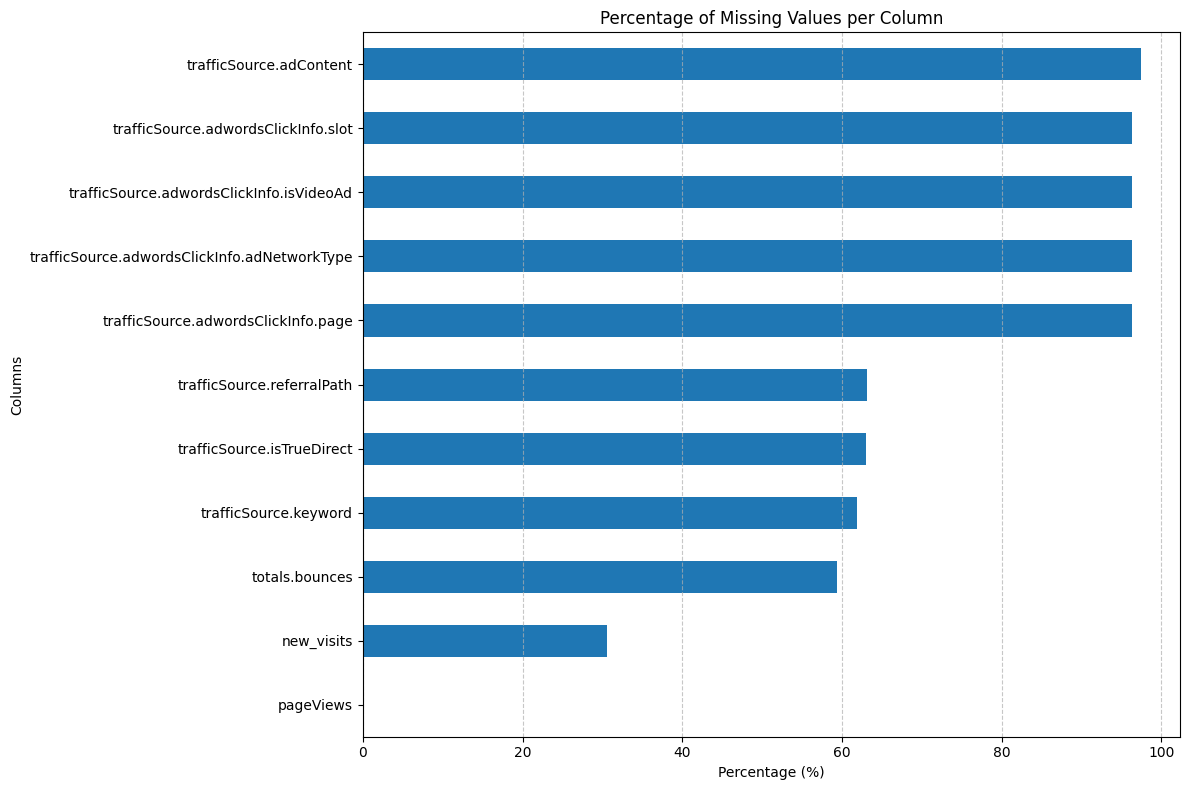

trafficSource.adContent                         97.446196
trafficSource.adwordsClickInfo.slot             96.310214
trafficSource.adwordsClickInfo.isVideoAd        96.310214
trafficSource.adwordsClickInfo.adNetworkType    96.310214
trafficSource.adwordsClickInfo.page             96.310214
trafficSource.referralPath                      63.184886
trafficSource.isTrueDirect                      63.033192
trafficSource.keyword                           61.936857
totals.bounces                                  59.363230
new_visits                                      30.601691
pageViews                                        0.006895
dtype: float64

In [6]:
import matplotlib.pyplot as plt

# Calculate missing value percentages
missing_percent = train_df.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 8))
missing_percent.plot(kind='barh')
plt.title('Percentage of Missing Values per Column')
plt.xlabel('Percentage (%)')
plt.ylabel('Columns')
plt.gca().invert_yaxis()  # Show highest missing at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

missing_percentage=missing_percent[missing_percent > 0]
missing_percentage

The graph above indicates that the following columns have over 60% of their values as null:

    'trafficSource.isTrueDirect'

    'trafficSource.keyword'

    'trafficSource.adwordsClickInfo.isVideoAd'

    'trafficSource.adwordsClickingInfo.adNetworkType'

    'trafficSource.adwordsClickInfo.page'

    'trafficSource.referralPath'

    'totals.bouncers'

# **How Many People have Purchased ?**

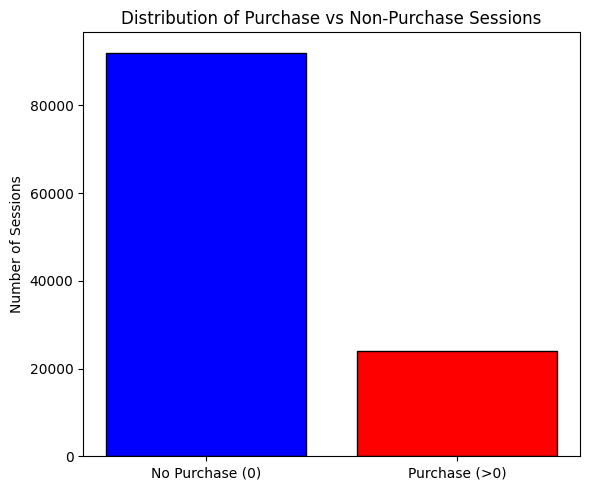

purchaseValue
False    92038
True     23985
Name: count, dtype: int64

In [7]:
import matplotlib.pyplot as plt

# Create a binary flag: 0 = no purchase, 1 = purchase made
purchase_flags = (train_df['purchaseValue'] > 0)

# Count of each class
purchase_counts = purchase_flags.value_counts().sort_index()
labels = ['No Purchase (0)', 'Purchase (>0)']

# Plot
plt.figure(figsize=(6, 5))
plt.bar(labels, purchase_counts, color=['blue', 'red'], edgecolor='black')
plt.title('Distribution of Purchase vs Non-Purchase Sessions')
plt.ylabel('Number of Sessions')
#plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

purchase_counts

# **Examining the correlation between the target column and other numeric columns, as well as the relationships among them.**

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


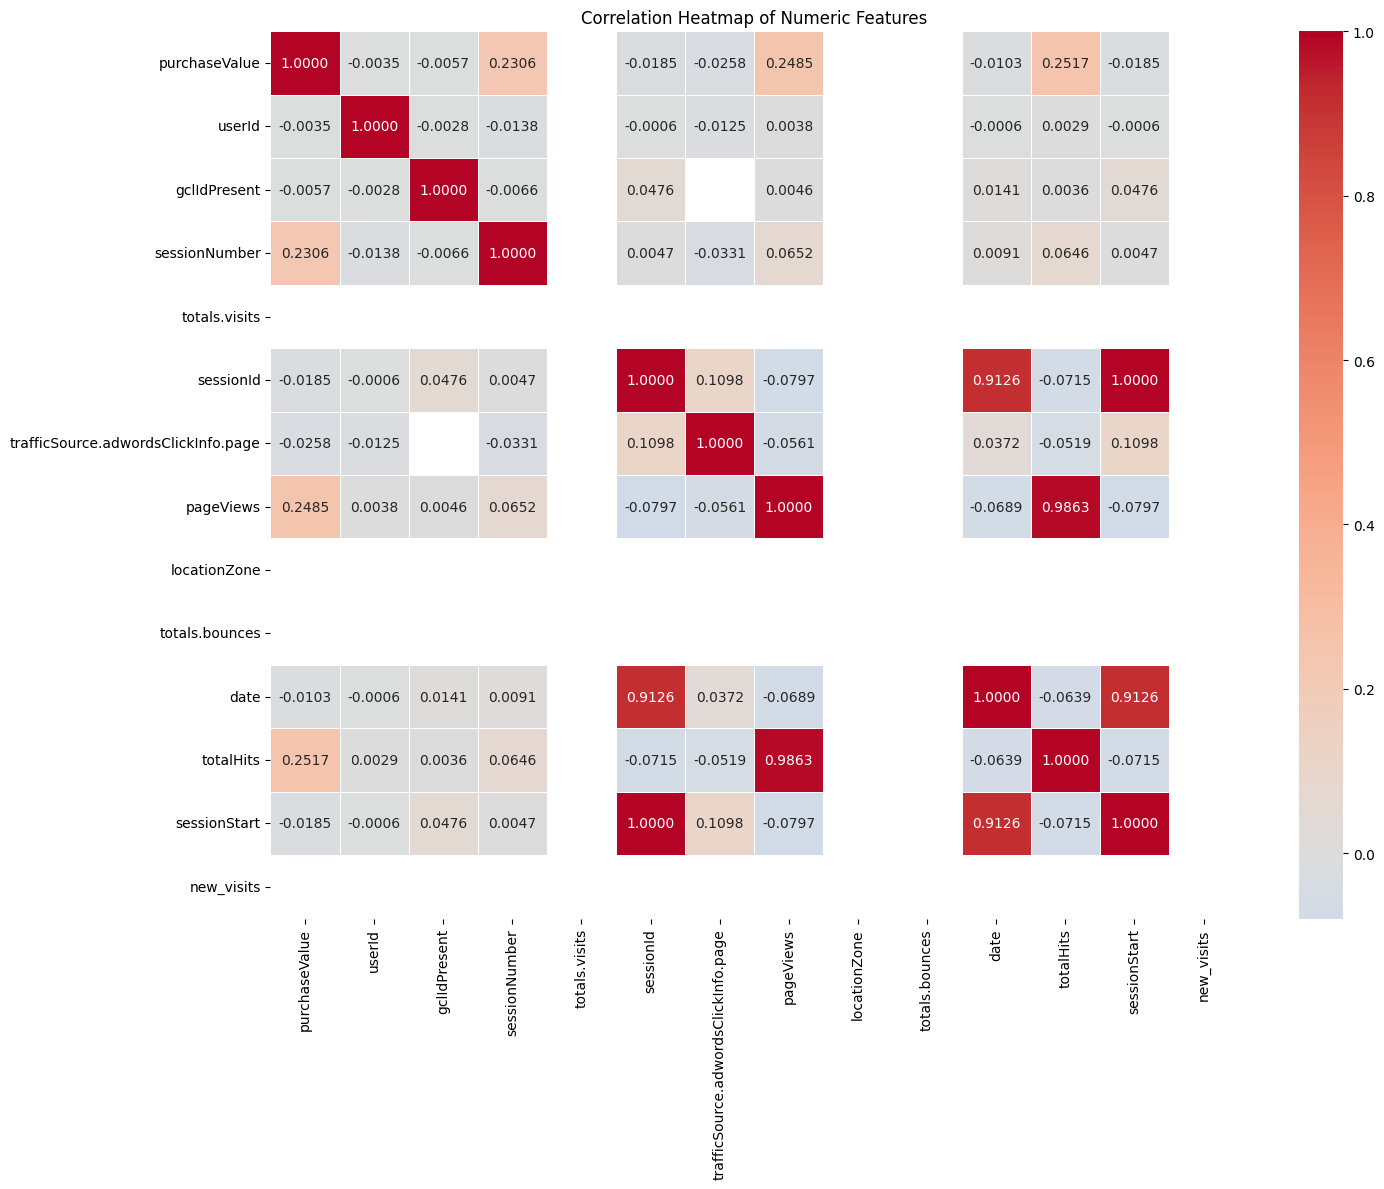

Correlation of Numeric Features with Target (purchaseValue):

totalHits                              0.251651
pageViews                              0.248454
sessionNumber                          0.230585
userId                                -0.003469
gclIdPresent                          -0.005652
date                                  -0.010338
sessionStart                          -0.018537
sessionId                             -0.018537
trafficSource.adwordsClickInfo.page   -0.025839
totals.visits                               NaN
locationZone                                NaN
totals.bounces                              NaN
new_visits                                  NaN
Name: purchaseValue, dtype: float64


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_cols = train_df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# 1. Heatmap of correlations
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".4f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

# 2. Correlation of each numeric feature with purchaseValue
target_corr = corr_matrix['purchaseValue'].drop('purchaseValue').sort_values(ascending=False)

# Print correlation list
print("Correlation of Numeric Features with Target (purchaseValue):\n")
print(target_corr)

From the Plot :
1. The correlation analysis shows that totalHits (0.25), pageViews (0.25), and sessionNumber (0.23) have the strongest positive correlations with purchaseValue.
2. userId, gclIdPresent, date, sessionStart, sessionId, and trafficSource.adwordsClickInfo.page show negligible negative correlations.
3. Columns with NaN values, like totals.visits, locationZone, totals.bounces, and new_visits, likely have constant values, making them irrelevant for the analysis.

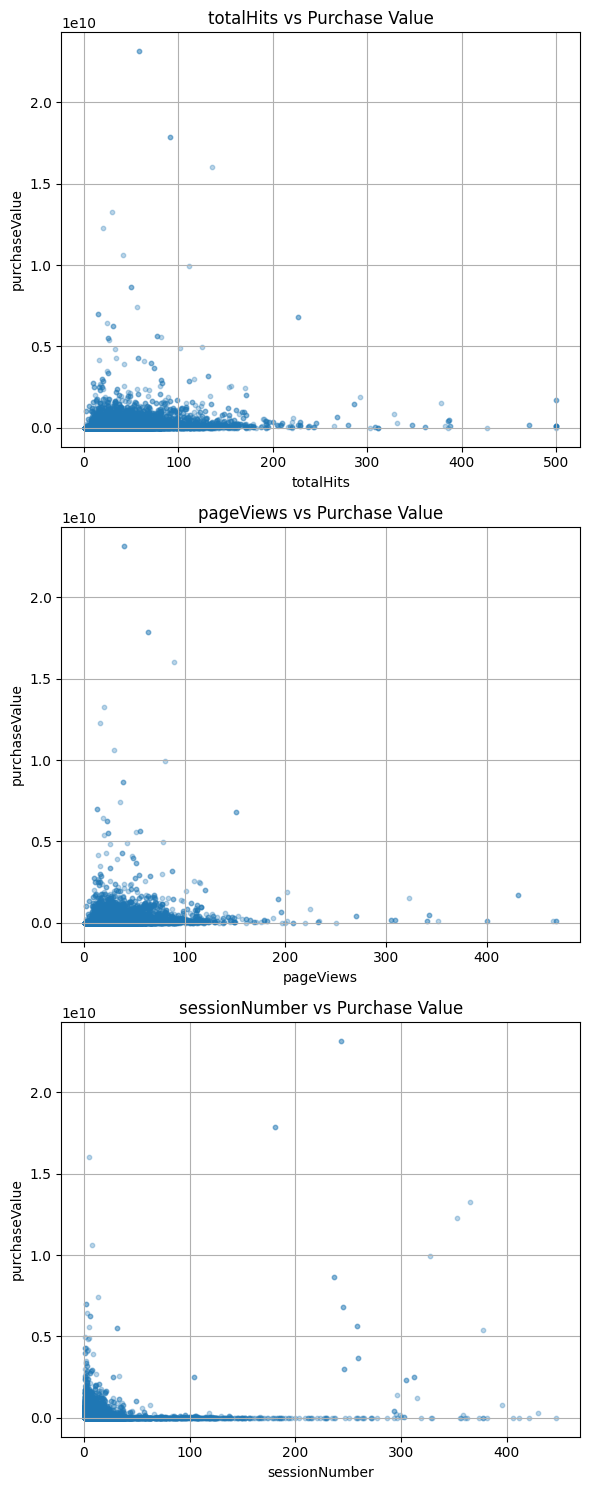

In [9]:
import matplotlib.pyplot as plt

# List of top positively correlated features
top_features = ['totalHits', 'pageViews', 'sessionNumber']

# Set up subplots
plt.figure(figsize=(6,15 ))

for i, col in enumerate(top_features):
    plt.subplot(3, 1, i+1)
    plt.scatter(train_df[col], train_df['purchaseValue'], alpha=0.3, s=10)
    plt.title(f'{col} vs Purchase Value')
    plt.xlabel(col)
    plt.ylabel('purchaseValue')
    plt.grid(True)

plt.tight_layout()
plt.show()


1. PageViews & PurchaseValue: Most users have low pageViews and purchaseValue, indicating minimal interaction. A few users with low pageViews have high purchaseValue, suggesting quick, high-value conversions. As pageViews increase, purchaseValue tends to stay low or decrease, with no strong positive correlation. There's a long tail of high pageViews but low purchases.
2. SessionNumber & PurchaseValue: The relationship is similar to that of pageViews and purchaseValue, with no clear pattern. Most purchases occur in early sessions (low sessionNumber), while high-value purchases are spread across various sessionNumbers. Most users have low or zero purchaseValue, regardless of sessionNumber, and there’s no strong linear relationship. High spikes suggest outliers.
3. TotalHits & PurchaseValue: The pattern between totalHits and purchaseValue mirrors the relationship between pageViews and purchaseValue.


In [10]:
# Step 2 – Column summary: unique count, top 3 values, and their %s

def get_column_summary(df):
    summary = []

    for col in df.columns:
        value_counts = df[col].value_counts(dropna=False)
        top_vals = value_counts.head(3)
        top_vals_perc = (top_vals / len(df)) * 100

        summary.append({
            'Column': col,
            'Unique_Values': df[col].nunique(dropna=False),
            'Top_1': f"{top_vals.index[0]} ({top_vals_perc.iloc[0]:.2f}%)" if len(top_vals) > 0 else None,
            'Top_2': f"{top_vals.index[1]} ({top_vals_perc.iloc[1]:.2f}%)" if len(top_vals) > 1 else None,
            'Top_3': f"{top_vals.index[2]} ({top_vals_perc.iloc[2]:.2f}%)" if len(top_vals) > 2 else None,
        })

    return pd.DataFrame(summary)

# Apply to train dataset
column_summary_df = get_column_summary(train_df)
pd.set_option('display.max_colwidth', None)  # So full values are visible
display(column_summary_df)

,Column,Unique_Values,Top_1,Top_2,Top_3
0,trafficSource.isTrueDirect,2,nan (63.03%),True (36.97%),None
1,purchaseValue,6766,0.0 (79.33%),16990000.0 (0.38%),18990000.0 (0.28%)
2,browser,34,Chrome (72.84%),Safari (16.53%),Firefox (3.47%)
3,device.screenResolution,1,not available in demo dataset (100.00%),None,None
4,trafficSource.adContent,54,nan (97.45%),Google Merchandise Store (1.22%),Google Merchandise Collection (0.56%)
5,trafficSource.keyword,567,nan (61.94%),(not provided) (33.67%),6qEhsCssdK0z36ri (1.00%)
6,screenSize,1,medium (100.00%),None,None
7,geoCluster,5,Region_2 (20.08%),Region_4 (20.06%),Region_3 (20.01%)
8,trafficSource.adwordsClickInfo.slot,4,nan (96.31%),Top (2.35%),RHS (1.34%)
9,device.mobileDeviceBranding,1,not available in demo dataset (100.00%),None,None


# **Categorical columns to analyze**

In [11]:

cat_columns = [
    'geoNetwork.Continent',
    'browser',
    'os',
    'geoCluster',
    'geoNetwork.networkDomain',
    'userChannel',
    'trafficSource.medium',
    'deviceType'
]

# **Defining Conversion Rate for Plotting Graphs**

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_conversion_rate(df, col,num):
    # Total users per category
    total_users = df.groupby(col)['userId'].nunique()

    # Users who made at least one purchase
    purchasing_users = df[df['purchaseValue'] > 0].groupby(col)['userId'].nunique()

    # Combine into one DataFrame
    conversion_df = pd.DataFrame({
        'Total Users': total_users,
        'Purchasing Users': purchasing_users
    }).fillna(0)

    # Compute conversion %
    conversion_df['Conversion Rate (%)'] = (conversion_df['Purchasing Users'] / conversion_df['Total Users']) * 100

    # Sort by conversion rate and show top 10
    conversion_df = conversion_df.sort_values(by='Conversion Rate (%)', ascending=False).head(num)

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.bar(conversion_df.index, conversion_df['Conversion Rate (%)'], color='teal', edgecolor='black')
    plt.title(f'User Conversion Rate by {col}')
    plt.ylabel('Conversion Rate (%)')
    plt.xlabel(col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print table
    print(f"\nTop {num} values for {col}:\n")
    print(conversion_df)

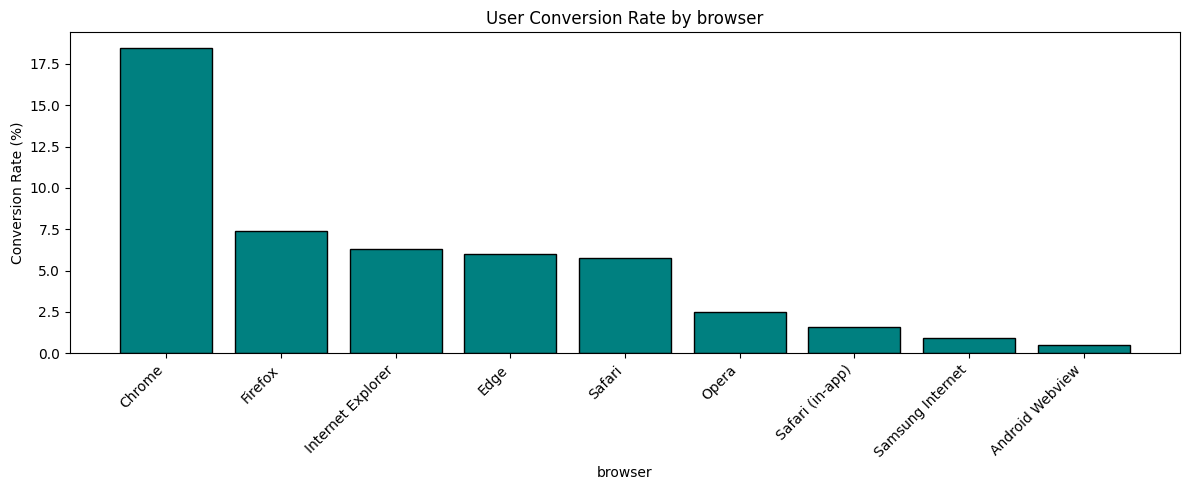


Top 9 values for browser:

                   Total Users  Purchasing Users  Conversion Rate (%)
browser                                                              
Chrome                   70951           13114.0            18.483179
Firefox                   3664             271.0             7.396288
Internet Explorer         2002             126.0             6.293706
Edge                      1114              67.0             6.014363
Safari                   17961            1030.0             5.734647
Opera                      523              13.0             2.485660
Safari (in-app)            768              12.0             1.562500
Samsung Internet           540               5.0             0.925926
Android Webview           1449               7.0             0.483092


In [13]:
plot_conversion_rate(train_df, 'browser',9)

The data shows that Chrome leads in both total users and conversions, with a high conversion rate of 18.48%. Other browsers like Firefox and Internet Explorer have significantly lower conversion rates, while browsers like Samsung Internet and Android Webview show very low conversion rates.

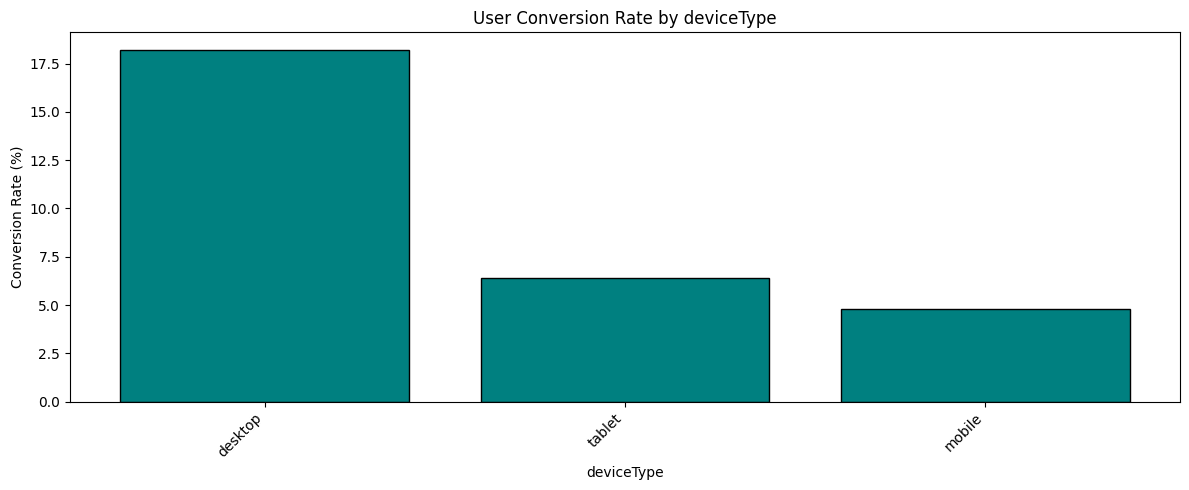


Top 3 values for deviceType:

            Total Users  Purchasing Users  Conversion Rate (%)
deviceType                                                    
desktop           72856             13265            18.207148
tablet             3446               220             6.384214
mobile            24197              1160             4.793983


In [14]:
plot_conversion_rate(train_df, 'deviceType',3) 

The data shows that desktop users have the highest conversion rate (18.21%) and total purchases, while mobile and tablet users have significantly lower conversion rates, with mobile having the lowest.

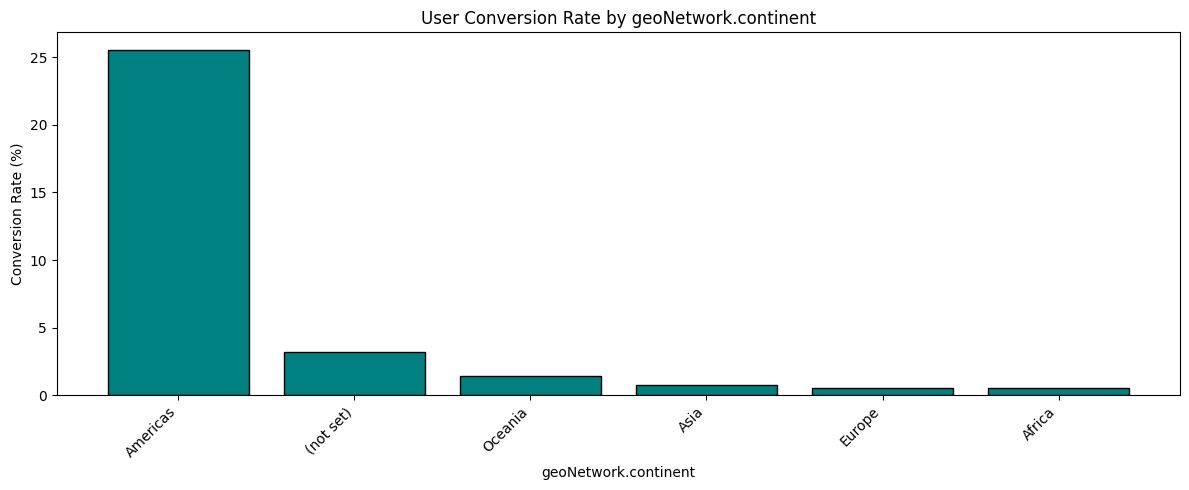


Top 6 values for geoNetwork.continent:

                      Total Users  Purchasing Users  Conversion Rate (%)
geoNetwork.continent                                                    
Americas                    56131             14349            25.563414
(not set)                     124                 4             3.225806
Oceania                      1554                22             1.415701
Asia                        21554               166             0.770159
Europe                      19478               109             0.559606
Africa                       1717                 9             0.524170


In [15]:
plot_conversion_rate(train_df, 'geoNetwork.continent',6)

The highest conversion rate is seen in the Americas (25.56%), followed by Oceania (1.42%). Regions like Asia, Europe, and Africa show significantly lower conversion rates, with Europe and Africa having the lowest. The "(not set)" value has a very low conversion rate as well.

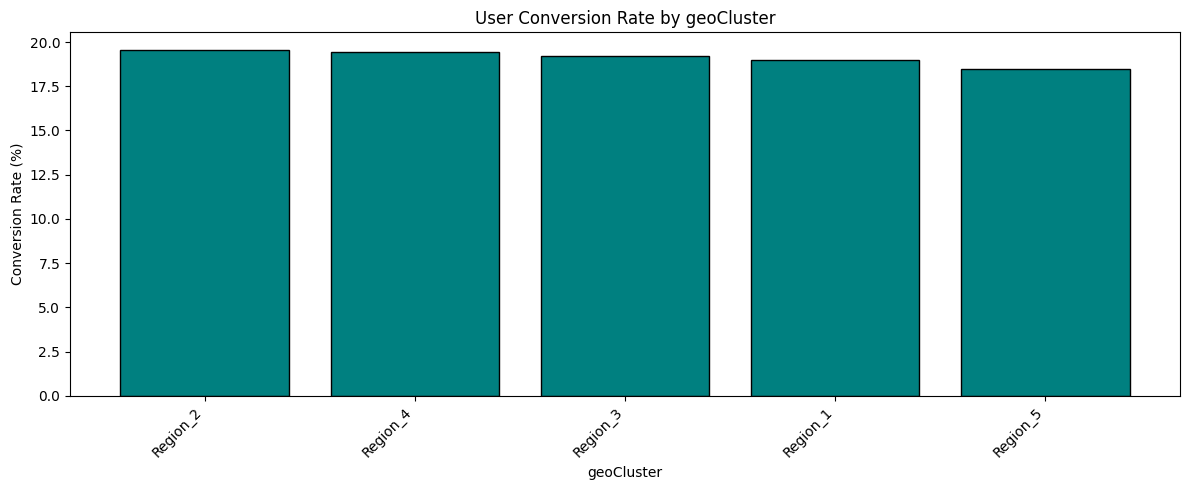


Top 5 values for geoCluster:

            Total Users  Purchasing Users  Conversion Rate (%)
geoCluster                                                    
Region_2          22372              4378            19.569104
Region_4          22374              4346            19.424332
Region_3          22299              4289            19.234046
Region_1          22118              4205            19.011665
Region_5          22368              4136            18.490701


In [16]:
plot_conversion_rate(train_df, 'geoCluster',5)

The data shows that all regions have similar conversion rates, with Region_2 having the highest at 19.57%, followed closely by Region_4, Region_3, Region_1, and Region_5, all ranging between 18.49% and 19.57%. The conversion rates across these regions are relatively high and consistent.

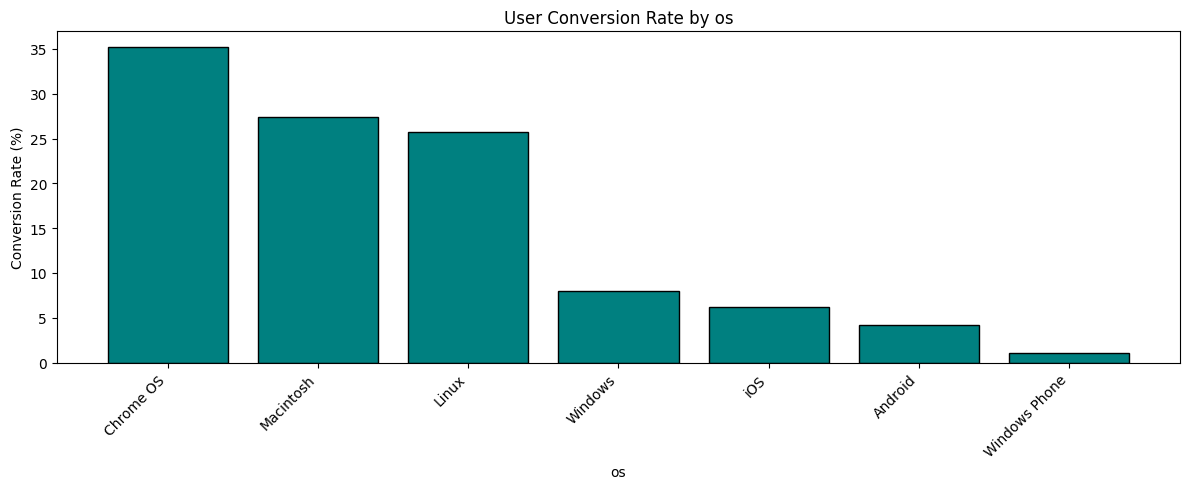


Top 7 values for os:

               Total Users  Purchasing Users  Conversion Rate (%)
os                                                               
Chrome OS             3485            1227.0            35.208034
Macintosh            29814            8157.0            27.359630
Linux                 4181            1076.0            25.735470
Windows              35493            2827.0             7.964951
iOS                  11879             733.0             6.170553
Android              14882             624.0             4.192985
Windows Phone           89               1.0             1.123596


In [17]:
plot_conversion_rate(train_df, 'os',7)  

Chrome OS has the highest conversion rate (35.21%), followed by Macintosh (27.36%) and Linux (25.74%). Windows also shows a decent user base but has a much lower conversion rate (7.96%), while mobile platforms like iOS and Android have even lower conversion rates. Windows Phone has the lowest conversion rate (1.12%) with a very small user base.

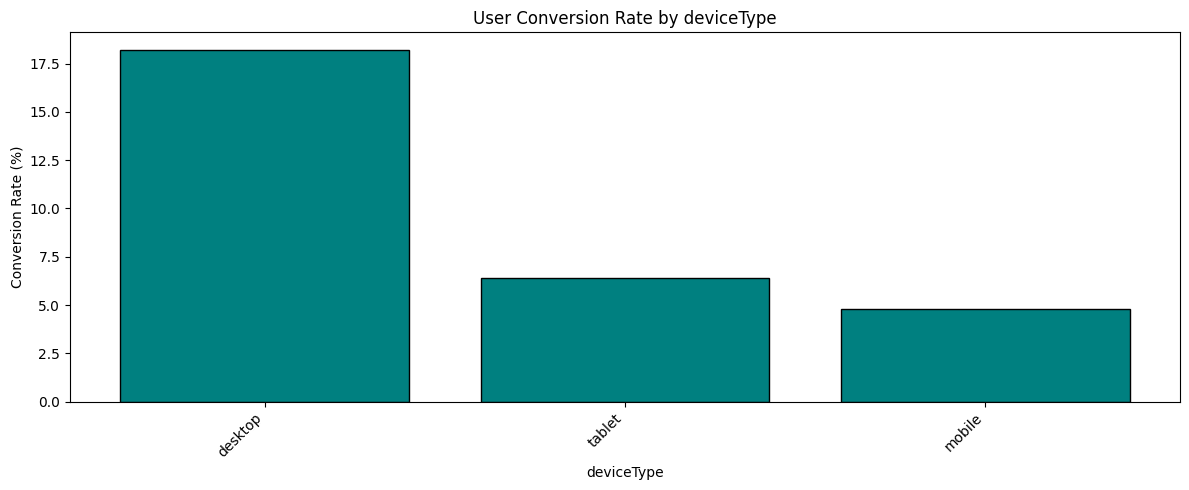


Top 3 values for deviceType:

            Total Users  Purchasing Users  Conversion Rate (%)
deviceType                                                    
desktop           72856             13265            18.207148
tablet             3446               220             6.384214
mobile            24197              1160             4.793983


In [18]:
plot_conversion_rate(train_df, 'deviceType',3)  

Desktop leads with the highest conversion rate (18.21%) and total purchases, followed by tablet (6.38%) and mobile (4.79%), indicating that desktop users are much more likely to convert than tablet or mobile users.

# **Group trafficSource into categories**

In [19]:
def categorize_source(source):
    if pd.isna(source):
        return 'Direct'

    source = str(source).lower()

    # 1. Google Organic Search
    if 'google' in source and not any(x in source for x in [
        'mail.', 'sites.', 'analytics.', 'docs.', 'support.', 'calendar.',
        'keep.', 'hangouts.', 'plus.', 'groups.', 'adwords.', 'myactivity.',
        'optimize.', 'googleplex', 'gdeals.', 'cases.', 'moma.', 'sandbox.'
    ]):
        return 'Google Search'

    # 2. Direct Traffic
    if source in ['(direct)', '(not set)', 'localhost']:
        return 'Direct'

    # 3. YouTube Referral
    if any(x in source for x in ['youtube.com', 'm.youtube.com', 'youtube.thinkwithgoogle.com']):
        return 'YouTube'

    # 4. Google Ecosystem Referral
    google_ecosystem_sources = [
        'analytics.google.com', 'sites.google.com', 'mail.google.com', 'groups.google.com',
        'plus.google.com', 'docs.google.com', 'support.google.com', 'optimize.google.com',
        'hangouts.google.com', 'keep.google.com', 'adwords.google.com', 'calendar.google.com',
        'myactivity.google.com'
    ]
    if any(g in source for g in google_ecosystem_sources):
        return 'Google Ecosystem'

    # 5. Social Media Referral
    if any(s in source for s in [
        'facebook.com', 'm.facebook.com', 'l.facebook.com',
        'reddit.com', 'm.reddit.com',
        'linkedin.com',
        'pinterest.com',
        'l.messenger.com',
        'm.vk.com', 'away.vk.com',
        't.co'
    ]):
        return 'Misc'

    # 6. Other Search Engines
    if any(e in source for e in [
        'bing', 'yahoo', 'baidu', 'duckduckgo', 'ask', 'msn.com', 'yandex', 'startpage'
    ]):
        return 'Misc'

    # 7. Paid Ads & Partner Referrals
    if any(p in source for p in [
        'dfa', 'partners', 'googleads.g.doubleclick.net', 'tpc.googlesyndication.com'
    ]):
        return 'Paid Ads'

    # 8. Internal / Corporate Referral
    if any(s in source for s in [
        'mall.googleplex.com', 'gdeals.googleplex.com', 'moma.corp.google.com',
        'dynamite.sandbox.google.com', 'cases.corp.google.com'
    ]):
        return 'Google Internal'

    # 9. General Website Referral
    return 'Misc'

In [20]:


train_df['traffic_source_category'] = train_df['trafficSource'].apply(categorize_source)


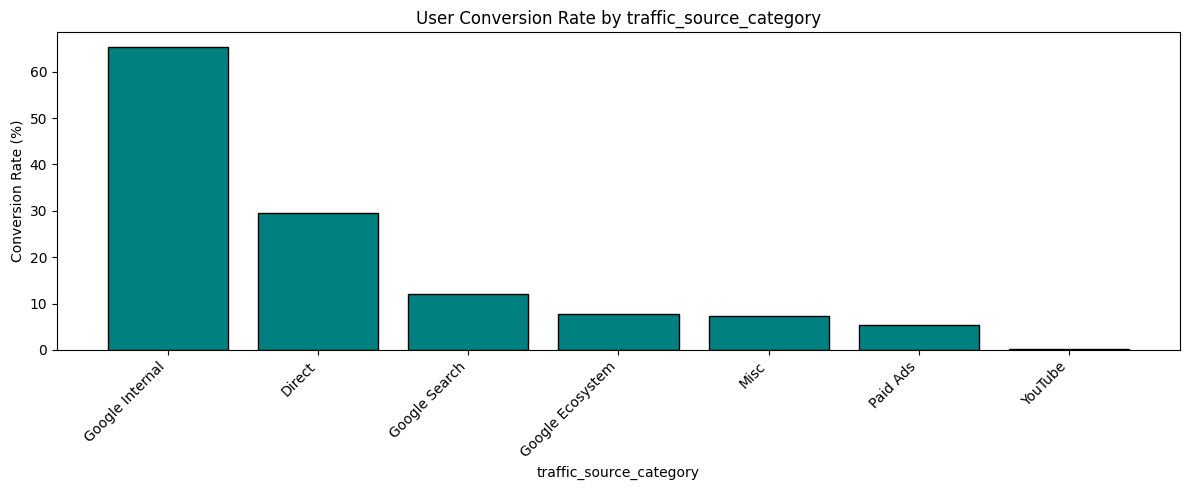


Top 7 values for traffic_source_category:

                         Total Users  Purchasing Users  Conversion Rate (%)
traffic_source_category                                                    
Google Internal                 5588              3644            65.211167
Direct                         32285              9567            29.632956
Google Search                  41425              4960            11.973446
Google Ecosystem                2707               208             7.683783
Misc                            2760               201             7.282609
Paid Ads                        2180               118             5.412844
YouTube                        18802                21             0.111690


In [21]:
plot_conversion_rate(train_df, 'traffic_source_category',7)  # or any other column

"Google Internal" has the highest conversion rate (65.21%) by a large margin, followed by Direct traffic (29.63%). Other sources like Google Search, Google Ecosystem, and Paid Ads have lower conversion rates, with YouTube having the lowest (0.11%) despite a relatively high number of users.

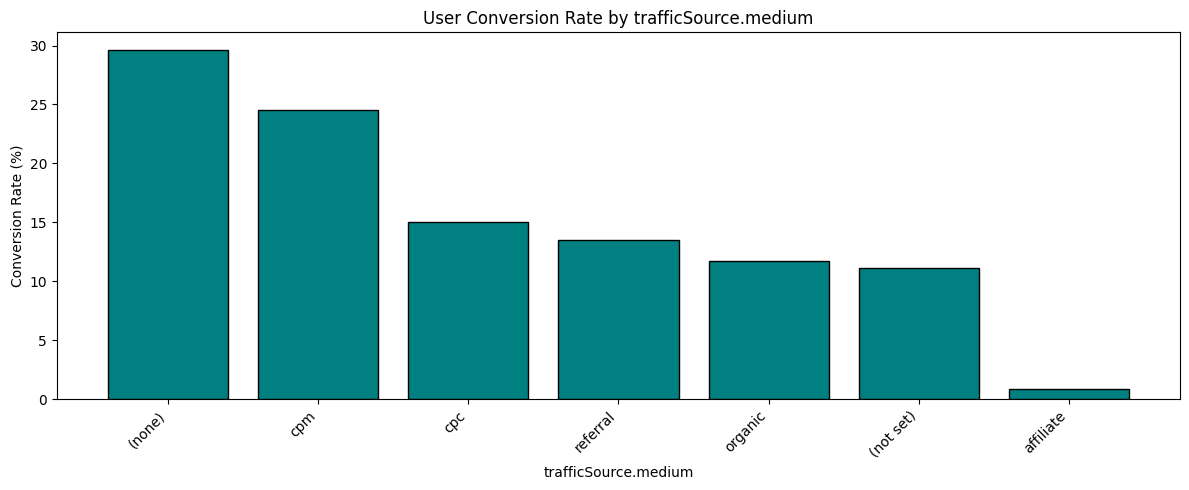


Top 7 values for trafficSource.medium:

                      Total Users  Purchasing Users  Conversion Rate (%)
trafficSource.medium                                                    
(none)                      32280              9567            29.637546
cpm                           620               152            24.516129
cpc                          3904               586            15.010246
referral                    29874              4032            13.496686
organic                     37436              4399            11.750721
(not set)                       9                 1            11.111111
affiliate                    1710                15             0.877193


In [22]:
plot_conversion_rate(train_df, 'trafficSource.medium',7)  # or any other column

The highest conversion rate is from "(none)" traffic (29.64%), followed by cpm (24.52%) and cpc (15.01%). Referral and organic traffic have decent conversion rates as well, while affiliate traffic has the lowest conversion rate (0.88%).

# **Group trafficSource.keyword into categories**

In [23]:


#import re

def categorize_keyword(keyword):
    if pd.isna(keyword):
        return 'none'

    keyword = keyword.lower()

    # Define keyword lists
    brand_keywords = ['google', 'youtube', 'youtyube', 'yotubi', 'you tube', 'youube', 'yoube', 'youtubb', 'you rube', 'youtoube', 'yutube',
                      'youtuge', 'yu tube', 'youyubr', 'yıutube', 'yutub e', 'you tubed', 'youtueb', 'youtubw', 'yootu', 'youteb', 'yot ube',
                      'you tuab', 'you tob', 'yu tupe', 'you thube', 'yooutube', 'you yube', 'youtuhe', 'yoou tube', 'yutude', 'youtub', 'youtubne',
                      'oyoutube', 'youtu be', 'ylutube', 'you tuba', 'yuotup', 'tyoutube', 'youtu b', 'youtove', 'joutube', 'iutube', 'iutubi',
                      'yorub', 'you tu', 'you tybe', 'utube', 'youtune', 'yourube', 'youyu', 'yoyu tube', 'android', 'chrome', 'nest', 'doubleclick']

    apparel_keywords = ['t shirt', 'tshirt', 't-shirt', 'teeshart', 'sharts', 'tsirt', 'tee', 'hoodie', 'jacket', 'apparel', 'shirt', 'shirts',
                        'hat', 'cap', 'baseball cap', 'socks', 'jersey', 'onesies', 'bodysuit', 'pullover', 'headgear']

    accessory_keywords = ['bag', 'bags', 'backpack', 'mug', 'mugs', 'pen', 'pens', 'sticker', 'stickers', 'bottle', 'water bottle', 'sunglasses',
                          'speaker', 'thermostat', 'headphones', 'flashlight', 'stylus pen', 'lava lamp', 'lava lights', 'power bank', 'gift card',
                          'decal', 'id card holder', 'tumbler']

    general_keywords = ['store', 'shop', 'shope', 'merchandise', 'merch', 'murchindise', 'merchandize', 'marchandise', 'merchendise', 'buy',
                        'purchase', 'online store', 'gift', 'products', 'accessories', 'items', 'gear', 'swag', 'paraphernalia', 'freebies',
                        'shopping', 'webshop']

    if '(not provided)' in keyword:
        return 'hidden'

    found = {
        'brand': any(k in keyword for k in brand_keywords),
        'apparel': any(k in keyword for k in apparel_keywords),
        'accessory': any(k in keyword for k in accessory_keywords),
        'general': any(k in keyword for k in general_keywords)
    }

    # Combine based on found keywords
    tags = [k for k, v in found.items() if v]

    if not tags:
        return 'misc'

    if 'brand' in tags:
        tags.remove('brand')
        if tags:
            return f"branded {' '.join(sorted(tags))}"
        else:
            return 'branded'
    else:
        return ' '.join(sorted(tags))



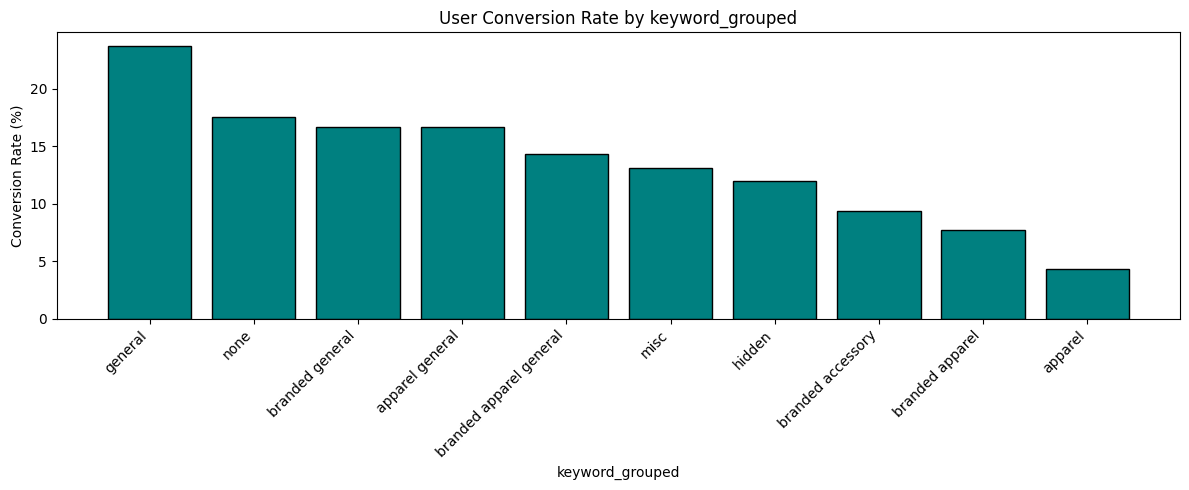


Top 10 values for keyword_grouped:

                         Total Users  Purchasing Users  Conversion Rate (%)
keyword_grouped                                                            
general                           59              14.0            23.728814
none                           61670           10797.0            17.507702
branded general                  922             154.0            16.702820
apparel general                   12               2.0            16.666667
branded apparel general           21               3.0            14.285714
misc                            3230             424.0            13.126935
hidden                         35934            4296.0            11.955251
branded accessory                 32               3.0             9.375000
branded apparel                  117               9.0             7.692308
apparel                           23               1.0             4.347826


In [24]:


train_df['keyword_grouped'] = train_df['trafficSource.keyword'].apply(categorize_keyword)
plot_conversion_rate(train_df, 'keyword_grouped',10) 

"General" has the highest conversion rate (23.73%), followed by "none" (17.51%) and "branded general" (16.70%). Keywords related to apparel and accessories, such as "apparel general" and "branded apparel," show lower conversion rates, with "apparel" having the lowest at 4.35%.

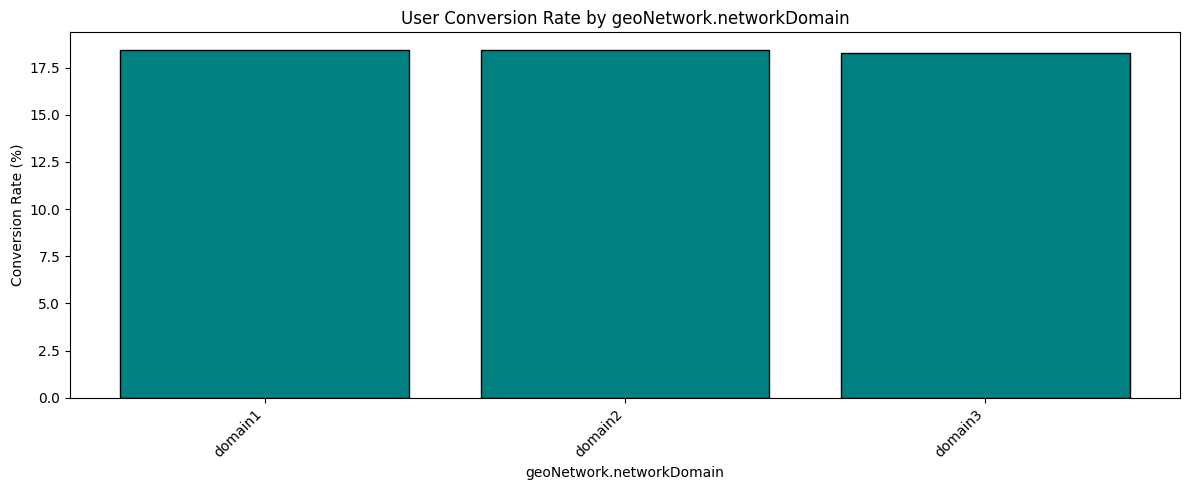


Top 3 values for geoNetwork.networkDomain:

                          Total Users  Purchasing Users  Conversion Rate (%)
geoNetwork.networkDomain                                                    
domain1                         36549              6742            18.446469
domain2                         36364              6701            18.427566
domain3                         36372              6639            18.253052


In [25]:
plot_conversion_rate(train_df, 'geoNetwork.networkDomain',3)

The top three network domains—domain1, domain2, and domain3—have very similar conversion rates, all around 18.45%, 18.43%, and 18.25%, respectively, indicating a consistent level of conversion across these domains.

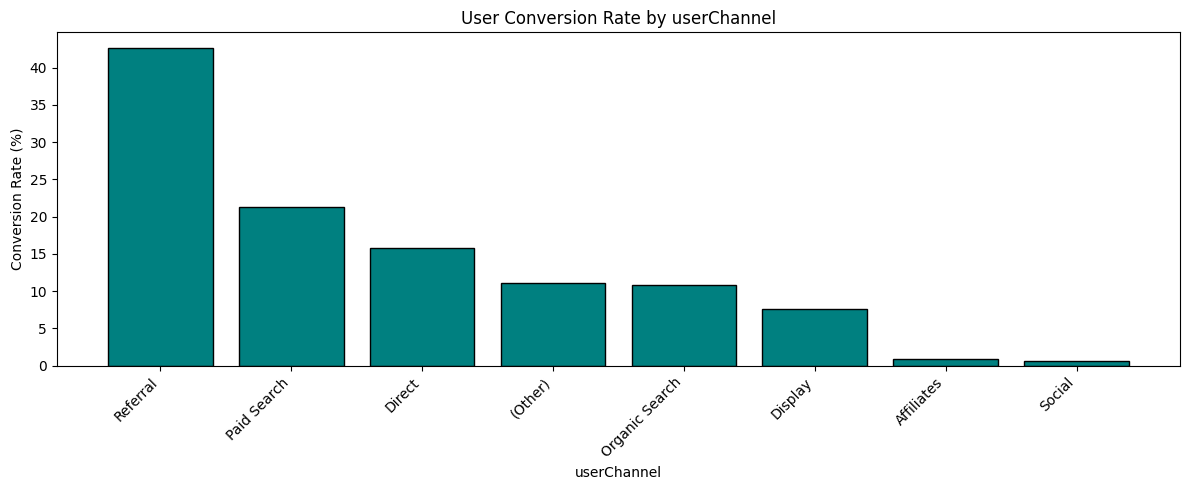


Top 8 values for userChannel:

                Total Users  Purchasing Users  Conversion Rate (%)
userChannel                                                       
Referral              15889              6769            42.601800
Paid Search            2874               612            21.294363
Direct                16161              2563            15.859167
(Other)                   9                 1            11.111111
Organic Search        42349              4576            10.805450
Display                2074               157             7.569913
Affiliates             1710                15             0.877193
Social                20245               141             0.696468


In [26]:
plot_conversion_rate(train_df, 'userChannel',8)

"Referral" has the highest conversion rate (42.60%), followed by "Paid Search" (21.29%) and "Direct" (15.86%). Organic Search also shows a solid conversion rate (10.81%), while channels like Display, Affiliates, and Social have significantly lower rates, with Social having the lowest (0.70%).

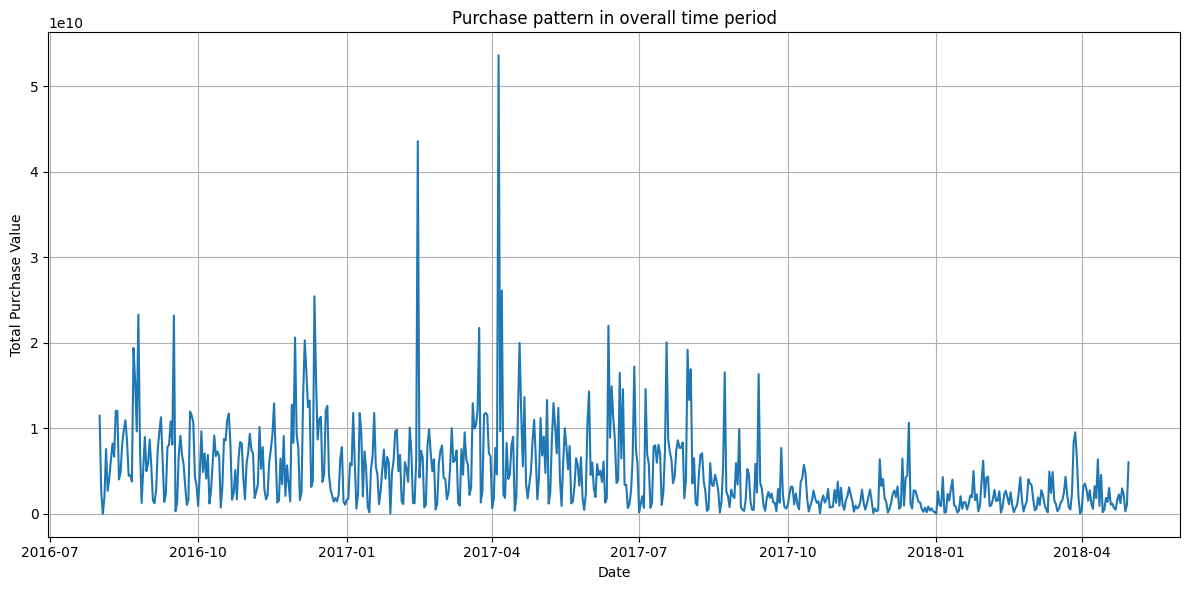

In [27]:
train_df['date'] = pd.to_datetime(train_df['date'], format='%Y%m%d')
daily_sales = train_df.groupby(train_df['date'].dt.date)['purchaseValue'].sum()


daily_sales.plot(kind='line', figsize=(12,6), title='Daily Total Purchase Value')
plt.xlabel('Date')
plt.ylabel('Total Purchase Value')
plt.title('Purchase pattern in overall time period')
plt.grid(True)
plt.tight_layout()
plt.show()

It can be observed that:

There were significant spikes in purchases, particularly between late 2016 and early 2017, indicating days with exceptionally high transaction volumes.

After mid-2017, both the frequency and value of purchases started to decline.

Overall, daily purchase values show considerable variability, with no consistent trend.

# **Extracting Datetime Features from sessionStart**

In [28]:
def extract_time_features(df):
    # Convert 'sessionStart' to datetime
    df['sessionStart'] = pd.to_datetime(df['sessionStart'], unit='s')

    # Extract time-based features (year, month, day, hour, weekday)
    for col in ['year', 'month', 'day', 'hour', 'weekday']:
        df[col] = getattr(df['sessionStart'].dt, col)

    # Create new features for weekend and monthly period
    df['is_weekend'] = df['weekday'].isin([5, 6])
    df['month_period'] = pd.cut(df["day"], bins=[0, 10, 20, 31], 
                                labels=["early", "mid", "late"], include_lowest=True).astype(str)

    # Time of day categorization
    def get_session_part(h):
        return 'morning' if 5 <= h < 12 else 'afternoon' if 12 <= h < 17 else 'evening' if 17 <= h < 21 else 'night'
    df['session_part'] = df['hour'].apply(get_session_part)

    # Cyclical features for time-related columns (month, weekday, day, hour)
    for col in ['month', 'weekday', 'day', 'hour']:
        df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
        df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())

    return df

In [29]:
train_df = extract_time_features(train_df)

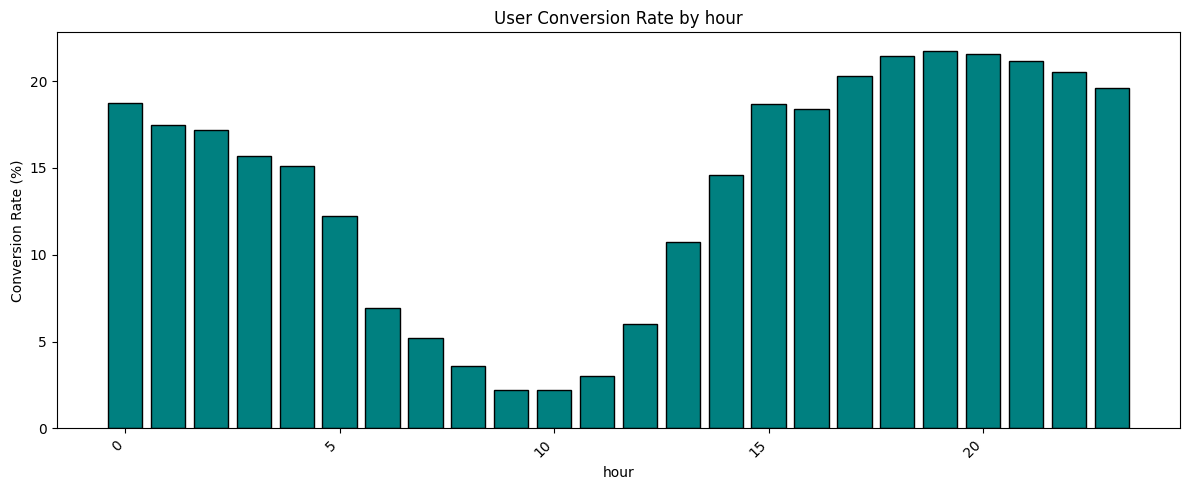


Top 24 values for hour:

      Total Users  Purchasing Users  Conversion Rate (%)
hour                                                    
19           5952              1293            21.723790
20           5772              1244            21.552322
18           6227              1335            21.438895
21           5517              1167            21.152800
22           5056              1038            20.530063
17           6277              1275            20.312251
23           4453               872            19.582304
0            4516               845            18.711249
15           5741              1071            18.655287
16           6061              1116            18.412803
1            3991               698            17.489351
2            3912               672            17.177914
3            3747               588            15.692554
4            3594               544            15.136338
14           5085               741            14.572271
5    

In [30]:
plot_conversion_rate(train_df, 'hour',24)

The data shows a clear trend where user engagement (both total and purchasing users) and conversion rates are highest in the evening hours (19:00-22:00) and decline overnight, with the lowest conversion rates occurring in the early morning hours (1:00-10:00)

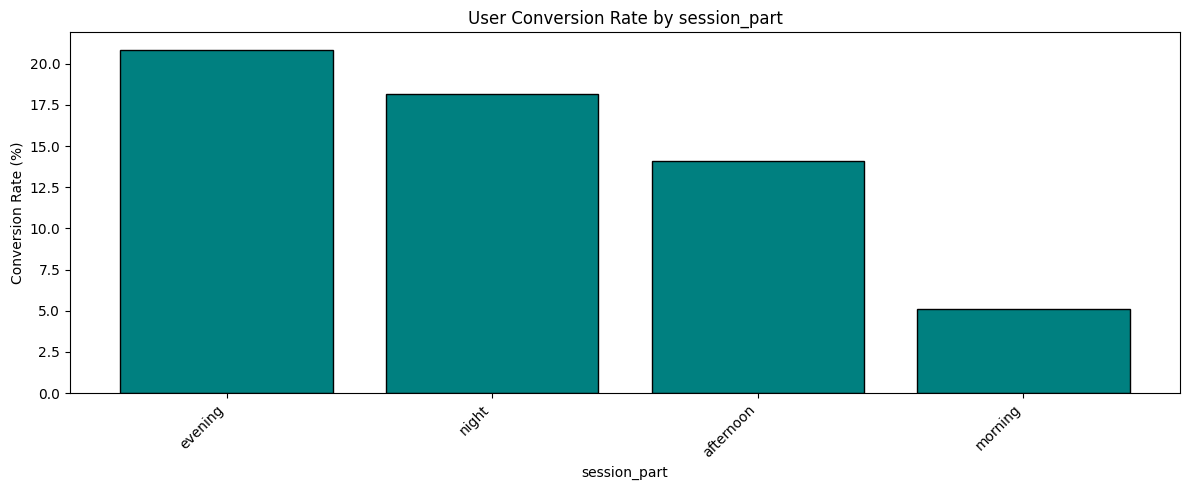


Top 8 values for session_part:

              Total Users  Purchasing Users  Conversion Rate (%)
session_part                                                    
evening             23559              4915            20.862515
night               33781              6134            18.158136
afternoon           24431              3446            14.105030
morning             22244              1134             5.098004


In [31]:
plot_conversion_rate(train_df, 'session_part',8)

The data reveals that the evening session has the highest conversion rate (20.86%), followed by night (18.16%), afternoon (14.11%), and morning (5.10%). This indicates that users are most likely to purchase in the evening, with conversion rates dropping throughout the day.

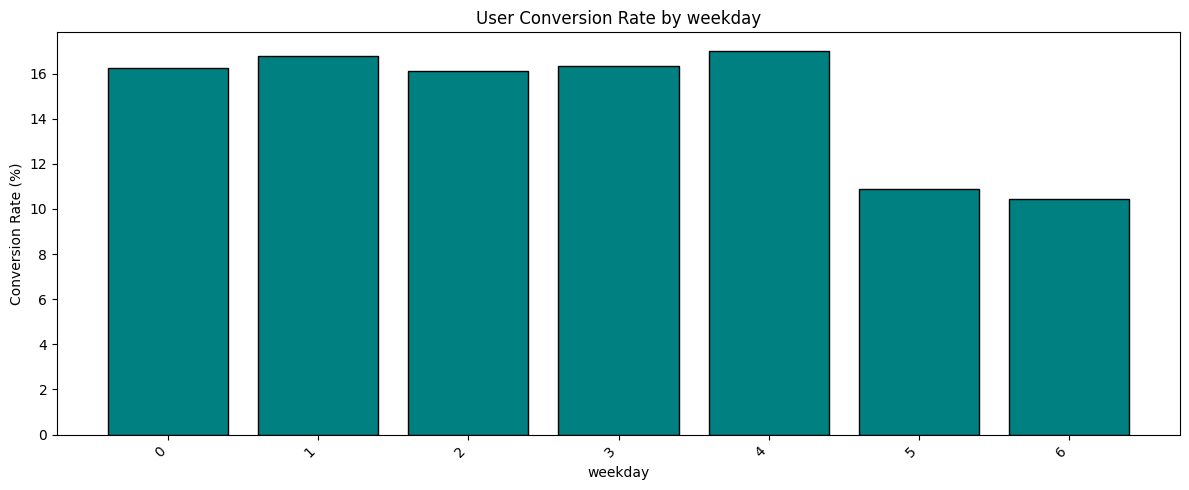


Top 7 values for weekday:

         Total Users  Purchasing Users  Conversion Rate (%)
weekday                                                    
4              15782              2680            16.981371
1              17069              2867            16.796532
3              16884              2757            16.329069
0              15862              2577            16.246375
2              17501              2817            16.096223
5              11424              1243            10.880602
6              10696              1118            10.452506


In [32]:
plot_conversion_rate(train_df, 'weekday',7)

The data shows that weekdays 0-4 (Monday to Friday) have similar conversion rates around 16%, with Friday (weekday 4) slightly leading. However, the weekend (Saturday and Sunday) sees a notable drop in conversion rates, with Saturday (weekday 5) and Sunday (weekday 6) seeing much lower engagement (around 10%).

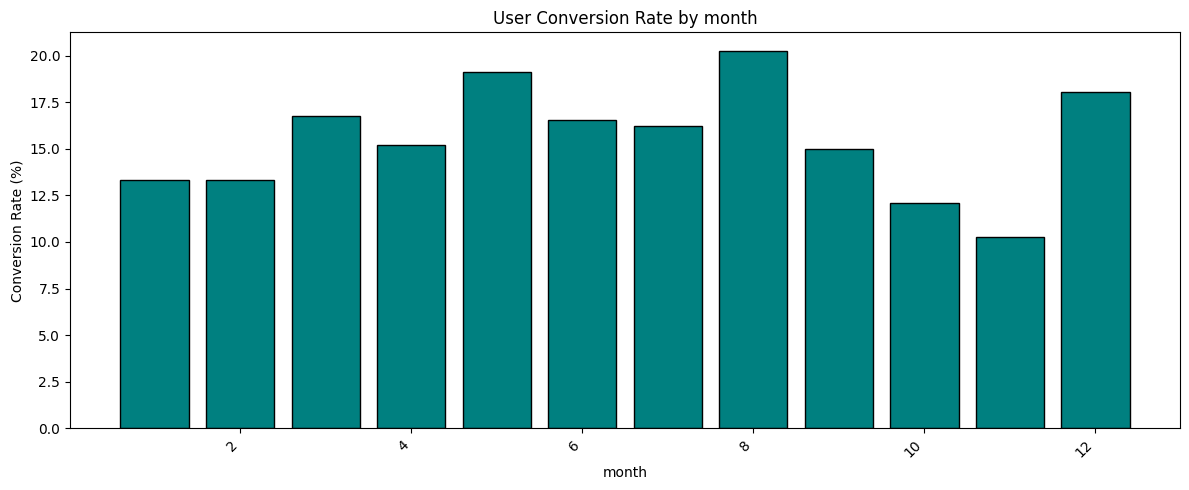


Top 12 values for month:

       Total Users  Purchasing Users  Conversion Rate (%)
month                                                    
8             9808              1985            20.238581
5             5424              1037            19.118732
12           10390              1874            18.036574
3             9443              1581            16.742561
6             5083               841            16.545347
7             5684               921            16.203378
4             8690              1322            15.212888
9             8964              1344            14.993307
2             8089              1080            13.351465
1             8295              1105            13.321278
10           11256              1362            12.100213
11           12351              1271            10.290665


In [33]:
plot_conversion_rate(train_df, 'month',12)

The data indicates that August (month 8) has the highest conversion rate at 20.24%, followed by May (19.12%) and December (18.04%). Conversion rates generally decline as the year progresses, with November (month 11) having the lowest rate at 10.29%.

In [34]:
import pandas as pd
import numpy as np

col_list = []

# Iterate through object and category columns
for col in train_raw.select_dtypes(include=['object', 'category']).columns:
    
    # Skip columns that have less than 2 unique values
    if train_raw[col].nunique() < 2:
        print(f"Column: {col}")
        print(train_raw[col].value_counts())
        print('\n')
        col_list.append(col)
        continue
    
    # For columns with more than 3 unique values, check the highest percentage value
    if train_raw[col].nunique() > 3:
        # Calculate the percentage distribution of values in the column
        value_counts = train_raw[col].value_counts(normalize=True)
        highest_percentage_value = value_counts.idxmax()
        highest_percentage = value_counts.max()
        
        # If the highest value is NaN, 'not set', or 'not available in demo dataset', drop the column
        if highest_percentage_value in [np.nan, 'not set', 'not available in demo dataset','not provided']:
            #print(f"Column: {col} has {highest_percentage*100:.2f}% of the value '{highest_percentage_value}', so it's being removed.")
            col_list.append(col)
        #else:
            #print(f"Column: {col} has {highest_percentage*100:.2f}% of '{highest_percentage_value}', but it's kept.")
            
    #else:
        # For columns with <= 3 unique values, you can keep them as is (no extra check needed)
        #print(f"Column: {col} has {train_raw[col].nunique()} unique values and is kept.")
    
# Final list of columns to be dropped
print("\nColumns to drop:", col_list)


Column: trafficSource.isTrueDirect
trafficSource.isTrueDirect
True    42890
Name: count, dtype: int64


Column: device.screenResolution
device.screenResolution
not available in demo dataset    116023
Name: count, dtype: int64


Column: screenSize
screenSize
medium    116023
Name: count, dtype: int64


Column: device.mobileDeviceBranding
device.mobileDeviceBranding
not available in demo dataset    116023
Name: count, dtype: int64


Column: device.mobileInputSelector
device.mobileInputSelector
not available in demo dataset    116023
Name: count, dtype: int64


Column: device.mobileDeviceMarketingName
device.mobileDeviceMarketingName
not available in demo dataset    116023
Name: count, dtype: int64


Column: device.operatingSystemVersion
device.operatingSystemVersion
not available in demo dataset    116023
Name: count, dtype: int64


Column: device.flashVersion
device.flashVersion
not available in demo dataset    116023
Name: count, dtype: int64


Column: geoNetwork.networkLocation
geoNet

In [35]:
# Identify removable columns
removable_cols = [col for col in train_raw.columns if col in col_list]


# Print removable columns in a vertical list
if removable_cols:
    print("Dropped columns:")
    for col in removable_cols:
        print(col)
else:
    print("No columns to drop.")

# Drop removable columns
train_clean = train_raw.drop(columns=removable_cols, errors='ignore')
test_clean = test_raw.drop(columns=removable_cols, errors='ignore')

# Preparing final datasets
y_train_orig = train_clean['purchaseValue'].copy()
train_df_orig = train_clean.drop('purchaseValue', axis=1)
test_df_orig = test_clean.copy()



Dropped columns:
trafficSource.isTrueDirect
device.screenResolution
screenSize
device.mobileDeviceBranding
device.mobileInputSelector
device.mobileDeviceMarketingName
device.operatingSystemVersion
device.flashVersion
geoNetwork.region
geoNetwork.networkLocation
trafficSource.adwordsClickInfo.isVideoAd
browserMajor
device.browserSize
socialEngagementType
geoNetwork.city
geoNetwork.metro
device.mobileDeviceModel
device.language
device.browserVersion
device.screenColors


In [36]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 32 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   purchaseValue                                 116023 non-null  float64
 1   browser                                       116023 non-null  object 
 2   trafficSource.adContent                       2963 non-null    object 
 3   trafficSource.keyword                         44162 non-null   object 
 4   geoCluster                                    116023 non-null  object 
 5   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 6   userId                                        116023 non-null  int64  
 7   trafficSource.campaign                        116023 non-null  object 
 8   geoNetwork.networkDomain                      116023 non-null  object 
 9   gclIdPresent                                  11

In [37]:
test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29006 entries, 0 to 29005
Data columns (total 31 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   userChannel                                   29006 non-null  object 
 1   date                                          29006 non-null  int64  
 2   browser                                       29006 non-null  object 
 3   deviceType                                    29006 non-null  object 
 4   device.isMobile                               29006 non-null  bool   
 5   os                                            29006 non-null  object 
 6   geoNetwork.continent                          29006 non-null  object 
 7   locationCountry                               29006 non-null  object 
 8   geoNetwork.networkDomain                      29006 non-null  object 
 9   geoNetwork.subContinent                       29006 non-null 

In [38]:
def impute_binary_nan(df):
    for col in df.columns:
        values = df[col].dropna().unique()
        if df[col].isna().sum() > 0 and len(values) == 1:
            val = values[0]

            # Determine imputation based on value type
            if val is True:
                df[col] = df[col].fillna(False)
            elif val is False:
                df[col] = df[col].fillna(True)
            elif val == 1:
                df[col] = df[col].fillna(0)
            elif val == 0:
                df[col] = df[col].fillna(1)
            elif val == 1.0:
                df[col] = df[col].fillna(0.0).astype(int)
            elif val == 0.0:
                df[col] = df[col].fillna(1.0).astype(int)
    return df

def convert_binary_columns_to_bool(df):
    for col in df.columns:
        unique_vals = df[col].dropna().unique()

        # Proceed only if exactly 2 unique values
        if len(unique_vals) == 2:
            # Sort values for consistency in mapping
            unique_vals = sorted(unique_vals)
            mapping = {unique_vals[0]: False, unique_vals[1]: True}

            df[col] = df[col].map(mapping).astype(bool)

            #print(f"✅ Converted column '{col}' to bool")

    return df

In [39]:
ordinal_mappings_dict = { 
    "session_part": ['night', 'morning', 'afternoon', 'evening'],
    "month_period": ['early', 'mid', 'late'] }



browser_mapping_dict = {
# Chrome-based
    'Chrome': 'Chrome',
    'Android Webview': 'Chrome',
    'Coc Coc': 'Chrome',
    'Iron': 'Chrome',
    'MRCHROME': 'Chrome',

    # Safari-based
    'Safari': 'Safari',
    'Safari (in-app)': 'Safari',

    # Firefox-based
    'Firefox': 'Firefox',
    'Mozilla': 'Firefox',
    'Mozilla Compatible Agent': 'Firefox',

    # Microsoft
    'Internet Explorer': 'Microsoft',
    'Edge': 'Microsoft',

    # Opera family
    'Opera': 'Opera',
    'Opera Mini': 'Opera',

    # Samsung
    'Samsung Internet': 'Samsung',

    # Other mobile browsers
    'Android Browser': 'OtherMobile',
    'UC Browser': 'OtherMobile',
    'Puffin': 'OtherMobile',
    'MQQBrowser': 'OtherMobile',

    # Other desktop/niche
    'Maxthon': 'OtherDesktop',
    'YaBrowser': 'OtherDesktop',
    'Seznam': 'OtherDesktop',

    # Gaming
    'Nintendo Browser': 'Error',
    'Playstation Vita Browser': 'Error',

    # Specific vendor or invalid
    'Amazon Silk': 'Error',
    'BlackBerry': 'Error',
    'LYF_LS_4002_12': 'Error',
    'M5': 'Error',
    'Browser': 'Error',
    'Nokia Browser': 'Error',
    'osee2unifiedRelease': 'Error',
    ';__CT_JOB_ID__:85da5736-a78e-45a9-837e-f5a53e5cd725;': 'Error',
    'no-ua': 'Error',
    '(not set)': 'Error',
    'Edge': 'Error',
    'Opera': 'Error',
    'UC Browser': 'Error',
    'YaBrowser': 'Error',
    'Android Browser': 'Error',
    'Maxthon': 'Error',
    'Puffin': 'Error',
    'Nokia Browser': 'Error',
    'Nintendo Browser': 'Error',
    'osee2unifiedRelease': 'Error',
    'ThumbSniper': 'Error',
    'YE': 'Error',
    'Lunascape': 'Error'

}

os_mapping_dict = {
    'Windows': 'Windows',
    'Macintosh': 'Macintosh',
    'Linux': 'Linux',
    'FreeBSD': 'Linux',
    'Chrome OS': 'Chrome',
    'Firefox OS': 'Other',
    'Android': 'Android',
    'iOS': 'iOS',
    'Windows Phone': 'Windows',
    'BlackBerry': 'Other',
    'Tizen': 'Other',
    'Samsung': 'Other',
    'Nintendo Wii': 'Other',
    'Nintendo WiiU': 'Other',
    'Playstation Vita': 'Other',
    'Xbox': 'Other',
    'OS/2': 'Other',
    '(not set)': 'Unknown',
}



In [40]:
target_encode_cols = ['userId', 'locationCountry','sessionNumber']
one_hot_encode_cols = ['userChannel',
                       'geoNetwork.continent',
                       'browser_group',
                       'os_group',
                       'keyword_grouped',
                       'month_period',
                       'session_part',
                       'traffic_source_category',
                      'geoCluster']
numeric_cols = [ 'sessionId',
                'pageViews',
                'totalHits',
                'month_sin','month_cos',
                'weekday_sin', 'weekday_cos',
                'day_sin', 'day_cos',
                'hour_sin', 'hour_cos',
                'year',
                'device.isMobile',
                'is_weekend',
                #'trafficSource.isTrueDirect',
                'totals.bounces',
                'new_visits' ]

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder


numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())                  
])



preprocessor = ColumnTransformer(
    transformers=[
        ('te', TargetEncoder(cols=target_encode_cols, handle_unknown='value'), target_encode_cols),
        ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), one_hot_encode_cols),
        
        # Apply the entire numeric_pipeline to the numeric columns
        ('numeric', numeric_pipeline, numeric_cols)
    ],
    remainder='drop'
)

print("✅ Models and preprocessor are ready.")

✅ Models and preprocessor are ready.


In [41]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin



class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_mappings=None, browser_mapping=None, os_mapping=None, 
                 categorize_keyword=None, categorize_source=None):
        self.ordinal_mappings = ordinal_mappings
        self.browser_mapping = browser_mapping
        self.os_mapping = os_mapping
        self.categorize_keyword = categorize_keyword
        self.categorize_source = categorize_source
        
    def fit(self, X, y=None): 
        return self

    def transform(self, X):
        df = X.copy()

        # Apply browser and OS mapping
        df['browser_group'] = df['browser'].map(self.browser_mapping).fillna('Other')
        df['os_group'] = df['os'].map(self.os_mapping).fillna('Other')

        # Handle missing values in certain columns
        #for col in ['trafficSource.isTrueDirect', 'totals.bounces', 'new_visits']:
            #if col in df.columns:
                #df[col] = df[col].fillna(0).astype(int)

        # Use the helper function to extract time-related features
        df = extract_time_features(df)

        # Apply ordinal mappings if available
        if self.ordinal_mappings:
            for col, order in self.ordinal_mappings.items():
                if col in df.columns:
                    df[col] = df[col].map({v: i for i, v in enumerate(order)}).fillna(-1).astype(int)

        # Apply custom functions for categorizing 'trafficSource.keyword' and 'trafficSource'
        if self.categorize_keyword:
            df['keyword_grouped'] = df['trafficSource.keyword'].apply(self.categorize_keyword)

        if self.categorize_source:
            df['traffic_source_category'] = df['trafficSource'].apply(self.categorize_source)

        # Handle binary NaN values and convert binary columns to bool
        df = impute_binary_nan(df)
        df = convert_binary_columns_to_bool(df)

        # Drop original columns that have been transformed
        df.drop(columns=['browser', 'os', 'sessionStart'], inplace=True, errors='ignore')

        return df

# **DEFINING THE MODELS**

In [42]:
print("\n--- Step 3: Comparing baseline models with default parameters ---")

# Define a dictionary of contrasting models with their default (or simple) settings
models_to_compare = {
    "LightGBM (Default)": lgb.LGBMRegressor(random_state=42),
    #"Random Forest (Default)": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Ridge Regression": Ridge(random_state=42),
    "Linear Regression": LinearRegression()
}



--- Step 3: Comparing baseline models with default parameters ---


# **Model Comparison**

In [43]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_results = []

for name, model in models_to_compare.items():
    print(f"\n--- Evaluating: {name} ---")
    pipeline = Pipeline(steps=[
        ('feature_engineer', FeatureEngineer(ordinal_mappings=ordinal_mappings_dict, browser_mapping=browser_mapping_dict, os_mapping=os_mapping_dict, categorize_keyword=categorize_keyword, categorize_source=categorize_source)),
        ('preprocessing', preprocessor),
        ('regressor', model)
    ])
    cv_scores = cross_val_score(pipeline, train_df_orig, y_train_orig, cv=kf, scoring='r2', n_jobs=-1)
    model_results.append({'Model': name, 'Mean R2 Score': np.mean(cv_scores), 'Std Dev': np.std(cv_scores)})
    print(f"✅ {name} finished with Mean R2: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

print("\n\n--- Baseline Model Comparison ---")
results_df = pd.DataFrame(model_results).sort_values(by='Mean R2 Score', ascending=False)
display(results_df[['Model', 'Mean R2 Score', 'Std Dev']])

# We select our champion based on these results
CHAMPION_MODEL_NAME = "LightGBM (Default)"
print(f"\n✅ Champion model for tuning selected: {CHAMPION_MODEL_NAME}")


--- Evaluating: LightGBM (Default) ---


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ LightGBM (Default) finished with Mean R2: 0.3428 (+/- 0.1710)

--- Evaluating: Ridge Regression ---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.02415e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.87773e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.54346e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.85406e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarn

✅ Ridge Regression finished with Mean R2: 0.1705 (+/- 0.1905)

--- Evaluating: Linear Regression ---


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ Linear Regression finished with Mean R2: 0.1705 (+/- 0.1906)


--- Baseline Model Comparison ---


,Model,Mean R2 Score,Std Dev
0,LightGBM (Default),0.342769,0.171001
1,Ridge Regression,0.170474,0.190541
2,Linear Regression,0.170459,0.190550



✅ Champion model for tuning selected: LightGBM (Default)


# **Hyperparameter Tuning**

In [44]:
'''
import optuna
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

print(f"\n--- Step 4: Starting Hyperparameter Tuning for {CHAMPION_MODEL_NAME} ---")

# Define the Optuna objective function to find the best LGBM parameters
def objective(trial):
    """Optuna objective function for hyperparameter tuning of LGBM."""
    
    # Define hyperparameters to tune
    params = {
        'objective': 'tweedie',
        'metric': 'rmse',
        'tweedie_variance_power': trial.suggest_float('tweedie_variance_power', 1.1, 1.9),
        'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'n_jobs': -1,
        'seed': 42,
        'boosting_type': 'gbdt',
        'verbose': -1
    }

    # Initialize the LightGBM regressor model with the chosen parameters
    champion_model = lgb.LGBMRegressor(**params)
    
    # Define the pipeline with feature engineering, preprocessing, and the model
    pipeline = Pipeline(steps=[
        ('feature_engineer', FeatureEngineer(
            ordinal_mappings=ordinal_mappings_dict, 
            browser_mapping=browser_mapping_dict, 
            os_mapping=os_mapping_dict,
            categorize_keyword=categorize_keyword,  
            categorize_source=categorize_source
        )),
        ('preprocessing', preprocessor),
        ('regressor', champion_model)
    ])
    
    # Cross-validation to evaluate the model with the current hyperparameters
    kf_hpt = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, train_df_orig, y_train_orig, cv=kf_hpt, scoring='r2')
    
    # Return the mean R2 score as the objective for optimization
    return np.mean(scores)

# Set the verbosity level for Optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Create a study and optimize it for the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25, show_progress_bar=True)

# Print the best result after optimization
print("\n--- HPT Complete ---")
print(f"Best R2 score found: {study.best_value:.4f}")
print("Best parameters found: ", study.best_params)

# Store the best parameters for later use
best_params = study.best_params
'''


'\nimport optuna\nimport lightgbm as lgb\nfrom sklearn.model_selection import KFold, cross_val_score\nfrom sklearn.pipeline import Pipeline\n\nprint(f"\n--- Step 4: Starting Hyperparameter Tuning for {CHAMPION_MODEL_NAME} ---")\n\n# Define the Optuna objective function to find the best LGBM parameters\ndef objective(trial):\n    """Optuna objective function for hyperparameter tuning of LGBM."""\n    \n    # Define hyperparameters to tune\n    params = {\n        \'objective\': \'tweedie\',\n        \'metric\': \'rmse\',\n        \'tweedie_variance_power\': trial.suggest_float(\'tweedie_variance_power\', 1.1, 1.9),\n        \'n_estimators\': 2000,\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 0.05),\n        \'num_leaves\': trial.suggest_int(\'num_leaves\', 20, 300),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 5, 12),\n        \'min_child_samples\': trial.suggest_int(\'min_child_samples\', 20, 100),\n        \'subsample\': trial.suggest_float(\'su

In [45]:
import lightgbm as lgb
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define the best parameters (as you already have)
best_lgbm_params = {
    'objective': 'tweedie', 
    'metric': 'rmse', 
    'boosting_type': 'gbdt', 
    'n_jobs': -1, 
    'seed': 42, 
    'verbose': -1,
    'tweedie_variance_power': 1.570, 
    'learning_rate': 0.0272, 
    'num_leaves': 196, 
    'max_depth': 11,
    'min_child_samples': 41, 
    'subsample': 0.619, 
    'colsample_bytree': 0.722, 
    'reg_alpha': 1.760,
    'reg_lambda': 0.598, 
    'n_estimators': 2000
}

# Initialize the best model with the provided parameters
champion_model = lgb.LGBMRegressor(**best_lgbm_params)

# Define your pipeline with feature engineering and preprocessing steps
champion_pipeline = Pipeline(steps=[
    ('feature_engineer', FeatureEngineer(
        ordinal_mappings=ordinal_mappings_dict,
        browser_mapping=browser_mapping_dict,
        os_mapping=os_mapping_dict,
        categorize_keyword=categorize_keyword,  
        categorize_source=categorize_source 
    )),
    ('preprocessing', preprocessor),
    ('regressor', champion_model)
])

# Fit the model on the training data
print("\n--- Step 5: Training the champion model (Tuned LightGBM) for submission ---")
champion_pipeline.fit(train_df_orig, y_train_orig)
print("✅ Champion model training complete.")

# Make predictions on the training set to evaluate the model
train_predictions = champion_pipeline.predict(train_df_orig)

# Evaluate the model performance on the training set using R2 and RMSE
r2_train = r2_score(y_train_orig, train_predictions)
rmse_train = np.sqrt(mean_squared_error(y_train_orig, train_predictions))

# Print the evaluation scores
print(f"\n--- Model Evaluation on Training Data ---")
print(f"R2 Score on Training Data: {r2_train:.4f}")
print(f"RMSE on Training Data: {rmse_train:.4f}")

# Make predictions on the test set
print("\n--- Making predictions for submission ---")
final_predictions = champion_pipeline.predict(test_df_orig)

# Ensure no negative predictions
final_predictions[final_predictions < 0] = 0

# Prepare the submission DataFrame
submission_df = pd.DataFrame({'id': range(len(final_predictions)), 'purchaseValue': final_predictions})

# Save the predictions to a CSV file
submission_df.to_csv('submission.csv', index=False)
print("\n✅ Submission file 'submission.csv' has been created successfully!")

# Optionally, display the first few rows of the submission
display(submission_df.head())



--- Step 5: Training the champion model (Tuned LightGBM) for submission ---
✅ Champion model training complete.

--- Model Evaluation on Training Data ---
R2 Score on Training Data: 0.9981
RMSE on Training Data: 8967539.3966

--- Making predictions for submission ---

✅ Submission file 'submission.csv' has been created successfully!


,id,purchaseValue
0,0,3.577083e+07
1,1,1.093494e+07
2,2,5.392023e-03
3,3,1.459734e+01
4,4,1.091699e+04
